# Velocity model to polygon simulPS (nnl)
based on Daniel Trugman, 2024 + tips from C. Moody's analysis notebook   
Loïc Bachelot

In [1]:
import numpy as np
import pandas as pd
import pygmt
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
import os
import json

# read json for all polygons to get the input parameters
* Poly id: int
* olat, olon: origin for pyproj projection (center point)
* plat1, plat2: lcc only (min and max of lat)
*   xmin, xmax, xsep = -124.0, 124.0, 2.0  
    ymin, ymax, ysep = -124.0, 124.0, 2.0  
    zmin, zmax, zsep = -4.0, 100.0, 1.0    
    cartesian grid bounds for velocity model - must encompass all stations, default values  

In [2]:
with open("cascadia_poly.json", 'r+') as file:
    file_data = json.load(file)
file_data[0]

{'poly_id': 1.0,
 'olon': -123.7,
 'olat': 48.0,
 'plat1': 46.9,
 'plat2': 49.1,
 'xmin': -124.0,
 'xmax': 124.0,
 'xsep': 2.0,
 'ymin': -124.0,
 'ymax': 124.0,
 'ysep': 2.0,
 'zmin': -4.0,
 'zmax': 100.0,
 'zsep': 1.0,
 'minlon': -125.0,
 'maxlon': -122.4,
 'minlat': 46.9,
 'maxlat': 49.1}

# setup parameter for the selected polygon

In [51]:
### Setup

## Polygon Number: 1-10 and projection
poly = 3
pproj = "lcc" # "tmerc"
maxR = "200R"
print("Polygon", poly)

poly_param = file_data[poly-1]

# origin for pyproj projection
olat, olon = poly_param['olat'], poly_param['olon']

# lcc only
plat1, plat2 = poly_param['plat1'], poly_param['plat2']

# cartesian grid bounds for velocity model
#  - must encompass all stations!
xmin, xmax, xsep = poly_param['xmin'], poly_param['xmax'], poly_param['xsep']
ymin, ymax, ysep = poly_param['ymin'], poly_param['ymax'], poly_param['ysep']
zmin, zmax, zsep = poly_param['zmin'], poly_param['zmax'], poly_param['zsep']

Polygon 3


## set output path

In [52]:
# output files
out_dir = "../locations/nlloc3D"
out_fileP = f"{out_dir}/model/delph_simulps_poly{poly}_{pproj}_{maxR}_P.txt"
out_fileS = f"{out_dir}/model/delph_simulps_poly{poly}_{pproj}_{maxR}_S.txt"

## Define Projection

In [53]:
# projection setup
crs1 = CRS.from_proj4("+proj=longlat +ellps=WGS84")
if pproj == "lcc":
    crs2 = CRS.from_proj4("+proj={:} +ellps=WGS84 +lat_0={:.4f} +lon_0={:.4f} +lat_1={:.4f} +lon_2={:.4f} +units=km".format(
        pproj,olat,olon,plat1,plat2))
else:
    crs2 = CRS.from_proj4("+proj={:} +ellps=WGS84 +lat_0={:.4f} +lon_0={:.4f} +units=km".format(
        pproj,olat,olon))
proj = Transformer.from_crs(crs1,crs2)
iproj = Transformer.from_crs(crs2,crs1)

# Filter datasets and project

## load event list

In [54]:
evlist = "../locations/cascadia.earthquakes.filtered"
qdf = pd.read_csv(evlist, parse_dates=['DateTime'])

# filter events for polygon
qdf = qdf[
    (qdf['Longitude'] >= poly_param['minlon']) &
    (qdf['Longitude'] <= poly_param['maxlon']) &
    (qdf['Latitude'] >= poly_param['minlat']) &
    (qdf['Latitude'] <= poly_param['maxlat'])
]

# event bounds
qlon0, qlon1 = qdf["Longitude"].quantile([0,1]).values
qlat0, qlat1 = qdf["Latitude"].quantile([0,1]).values
qlonM, qlatM = (qlon0+qlon1)/2, (qlat0+qlat1)/2
print(qlonM,qlatM)

# projection
qxp, qyp = proj.transform(qdf["Longitude"],qdf["Latitude"])
qdf["X"] = qxp
qdf["Y"] = qyp

# useful for NonLinLoc
print("Projected seismicity bounds:")
print(qdf["X"].min(), qdf["X"].max())
print(qdf["Y"].min(), qdf["Y"].max())

# show results
qdf

-123.69200000000001 46.0004
Projected seismicity bounds:
-98.34504694939974 102.3539043696198
-122.15082088039674 122.8226723669208


,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,EventID,Source,X,Y
39,1970/09/03 03:38:37,46.8973,-123.0958,46.9,2.1,d,10836893,PNSN,46.068818,99.953108
118,1971/05/28 10:42:07,46.5903,-122.4315,14.6,3.4,d,10839063,PNSN,97.250671,66.395792
129,1971/06/16 22:49:32,46.6082,-122.5233,44.5,1.7,d,10839158,PNSN,90.184398,68.280276
185,1971/09/14 13:31:33,46.4772,-122.4320,11.3,2.5,d,10839748,PNSN,97.408813,53.819187
234,1971/12/13 20:59:03,47.0362,-123.4942,27.3,3.6,d,10852228,PNSN,15.652714,115.253177
...,...,...,...,...,...,...,...,...,...,...
194365,2024/06/22 15:05:31,46.5368,-122.4070,24.3,0.3,l,62017716,PNSN,99.223600,60.476475
194374,2024/06/23 03:12:40,46.3553,-122.4153,16.2,2.1,l,62017906,PNSN,98.906146,40.285945
194462,2024/06/28 04:35:24,46.3570,-122.4080,15.1,0.7,l,62011417,PNSN,99.465100,40.483872
194514,2024/07/01 04:21:36,46.1208,-122.4978,18.9,0.7,l,62020301,PNSN,92.941290,14.118270


## load stations

In [55]:
stlist = "../choosing_stations/cascadia.stations.filtered"

sdf = pd.read_csv(stlist, sep='|', parse_dates=['StartTime', 'EndTime'])
sdf

,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime,Operating_Time
0,BK,DANT,40.294601,-121.802101,967.0,"Paynes Creek, CA, USA",2024-06-27 17:40:00,2030-12-31 23:59:59,2378.263877
1,C8,BCOV,50.544200,-126.842700,33.0,"Beaver Cove, BC, CA",2020-03-31 00:00:00,2030-12-31 23:59:59,3927.999988
2,C8,BPCB,48.923600,-123.704500,31.0,"Bare Point, BC, CA",2008-03-19 00:00:00,2014-06-10 23:59:59,2274.999988
3,C8,FHRB,50.060400,-127.115800,5.0,"Fair Harbour, BC, CA",2009-03-12 00:00:00,2015-10-24 23:59:59,2417.999988
4,C8,MWAB,49.741100,-125.303200,1176.0,"Mount Washington, BC, CA",2009-07-31 00:00:00,2030-12-31 23:59:59,7823.999988
...,...,...,...,...,...,...,...,...,...
800,CN,VGZ,48.413000,-123.325000,67.0,"Victoria Gonzales, BC, CA",1994-07-21 00:00:00,2030-12-31 23:59:59,13312.999988
801,CN,WOSB,50.161000,-126.570000,961.0,"Woss, BC, CA",1998-11-17 00:00:00,2030-12-31 23:59:59,11732.999988
802,CN,WPB,49.648000,-123.209000,260.0,"Watts Point, BC, CA",1996-09-04 00:00:00,2030-12-31 23:59:59,12536.999988
803,CN,WSLR,50.127000,-122.921000,907.0,"Whistler, BC, CA",2003-05-09 00:00:00,2030-12-31 23:59:59,10098.999988


In [56]:
# load all stations
stlist = "../choosing_stations/cascadia.stations.filtered"

sdf = pd.read_csv(stlist, sep='|', parse_dates=['StartTime', 'EndTime'])

# filter stations for polygon
sdf = sdf[
    (sdf['Longitude'] >= poly_param['minlon']) &
    (sdf['Longitude'] <= poly_param['maxlon']) &
    (sdf['Latitude'] >= poly_param['minlat']) &
    (sdf['Latitude'] <= poly_param['maxlat'])
]


# find bounds
slat0, slat1 = sdf["Latitude"].min(), sdf["Latitude"].max()
slon0, slon1 = sdf["Longitude"].min(), sdf["Longitude"].max()
selv0, selv1 = sdf["Elevation"].min(), sdf["Elevation"].max()
print(f"min lon: {slon0}, max lon: {slon1}")
print(f"min lat: {slat0}, max lat: {slat1}")
print(f"min elevation: {selv0}, max elevation: {selv1}")
print()

# center point
slonC, slatC = np.round(0.5*(slon0+slon1),4), np.round(0.5*(slat0+slat1),4)
print(f"Center point lon: {slonC}, lat: {slatC}")
print()

# project coordinates
sxp, syp = proj.transform(sdf["Longitude"], sdf["Latitude"])
sdf["X"] = sxp
sdf["Y"] = syp
print(f"X min: {sdf["X"].min()}, X max: {sdf["X"].max()}")
print(f"Y min: {sdf["Y"].min()}, Y max: {sdf["Y"].max()}")
print()

# check bounds
assert sdf["X"].min() >= xmin
assert sdf["X"].max() <= xmax
assert sdf["Y"].min() >= ymin
assert sdf["Y"].max() <= ymax

# show dataframe
sdf


min lon: -124.07024, max lon: -122.401932
min lat: 45.02753, max lat: 47.08075
min elevation: 5.4, max elevation: 1130.0

Center point lon: -123.2361, lat: 46.0541

X min: -28.27793470777001, X max: 100.44969306512377
Y min: -108.0895647308553, Y max: 120.22042010062447


,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime,Operating_Time,X,Y
20,CC,CC,45.610920,-122.496130,66.66,Rainier Lahar Test Station,2019-01-01,2030-12-31 23:59:59,4382.999988,93.911013,-42.554342
37,CC,HUT1,45.611260,-122.496760,86.00,HUT 1,2023-02-10,2030-12-31 23:59:59,2881.999988,93.861311,-42.517283
54,CC,PR00,45.610920,-122.496130,66.66,Rainier Lahar Test Station,2019-01-01,2030-12-31 23:59:59,4382.999988,93.911013,-42.554342
95,GS,TAUL1,45.522769,-123.054179,56.00,"Cornelius Elementary School, Cornelius, OR,USA",2021-05-25,2030-12-31 23:59:59,3507.999988,50.458219,-52.848057
96,GS,TAUL2,45.518911,-123.109937,58.00,"Forest Grove Fire Dept, Forest Grove, OR, USA",2021-05-26,2030-12-31 23:59:59,3506.999988,46.105025,-53.310022
...,...,...,...,...,...,...,...,...,...,...,...
525,UW,TOUT,46.303180,-122.563060,821.50,"Weyerhaeuser Mt St Helens Tree Farm, Cowlitz C...",2023-06-04,2030-12-31 23:59:59,2767.999988,87.612402,34.321467
546,UW,WHGC,46.655991,-123.729866,5.40,"Willapa Harbor Golf Course, WA, USA",2019-02-03,2030-12-31 23:59:59,4349.999988,-2.287108,72.942066
550,UW,WPO,45.572830,-122.790527,335.40,"West Portland, OR, USA",1986-10-16,2030-12-31 23:59:59,16147.999988,70.994361,-47.086798
555,UW,YACT,45.932500,-122.419300,214.00,"Yacolt, WA, USA",2005-05-10,2030-12-31 23:59:59,9366.999988,99.339867,-6.720267


In [57]:
### Project

# create evenly spaced grid
xgrid, ygrid = np.meshgrid(
    np.arange(xmin,xmax+xsep/2,xsep),
    np.arange(ymin,ymax+ysep/2,ysep))

# print
print(xgrid)
print()
print(ygrid)
print()

# project 
lon_grid, lat_grid = iproj.transform(xgrid,ygrid)

# print
print(lon_grid)
print()
print(lat_grid)

[[-124. -122. -120. ...  120.  122.  124.]
 [-124. -122. -120. ...  120.  122.  124.]
 [-124. -122. -120. ...  120.  122.  124.]
 ...
 [-124. -122. -120. ...  120.  122.  124.]
 [-124. -122. -120. ...  120.  122.  124.]
 [-124. -122. -120. ...  120.  122.  124.]]

[[-124. -124. -124. ... -124. -124. -124.]
 [-122. -122. -122. ... -122. -122. -122.]
 [-120. -120. -120. ... -120. -120. -120.]
 ...
 [ 120.  120.  120. ...  120.  120.  120.]
 [ 122.  122.  122. ...  122.  122.  122.]
 [ 124.  124.  124. ...  124.  124.  124.]]

[[-125.26931988 -125.24401442 -125.21870867 ... -122.18129133
  -122.15598558 -122.13068012]
 [-125.26980934 -125.24449599 -125.21918235 ... -122.18081765
  -122.15550401 -122.13019066]
 [-125.2702991  -125.24497786 -125.21965632 ... -122.18034368
  -122.15502214 -122.1297009 ]
 ...
 [-125.33137539 -125.3050698  -125.27876387 ... -122.12123613
  -122.0949302  -122.06862461]
 [-125.33190432 -125.30559021 -125.27927575 ... -122.12072425
  -122.09440979 -122.06809568]


## load velocity model

In [58]:
### Load xarray dataset
f_nc = "../locations/velocity_interp_delph2018.nc"
# load 
velocity = xr.open_dataset(f_nc)

# show fields
velocity

<xarray.Dataset> Size: 15MB
Dimensions:    (lat: 68, lon: 65, depth: 105)
Coordinates:
  * lat        (lat) float64 544B 36.0 36.2 36.4 36.6 ... 48.8 49.0 49.2 49.4
  * lon        (lon) float64 520B -124.8 -124.6 -124.4 ... -112.4 -112.2 -112.0
  * depth      (depth) int64 840B -4 -3 -2 -1 0 1 2 3 ... 94 95 96 97 98 99 100
Data variables:
    Vp         (lat, lon, depth) float64 4MB ...
    Vs         (lat, lon, depth) float64 4MB ...
    Vs_interp  (depth, lat, lon) float64 4MB ...
    Vp_interp  (depth, lat, lon) float64 4MB ...

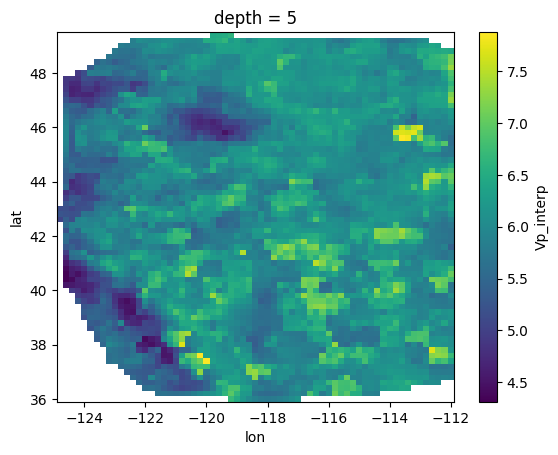

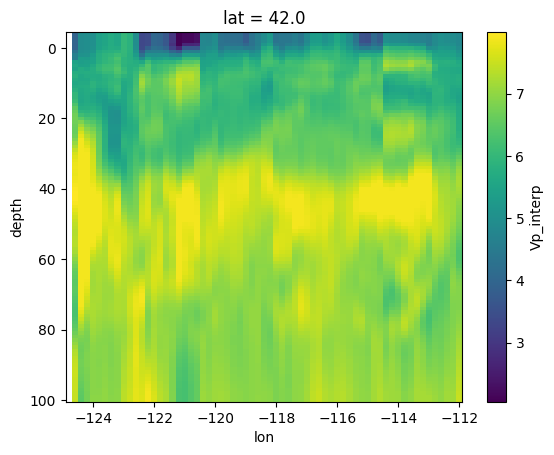

In [59]:
# fixed depth, map view
velocity['Vp_interp'].sel(depth = 5).plot()
plt.show()

# cross section
velocity['Vp_interp'].sel(lat = 42).plot(y = 'depth')
plt.gca().invert_yaxis()
plt.show()

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline


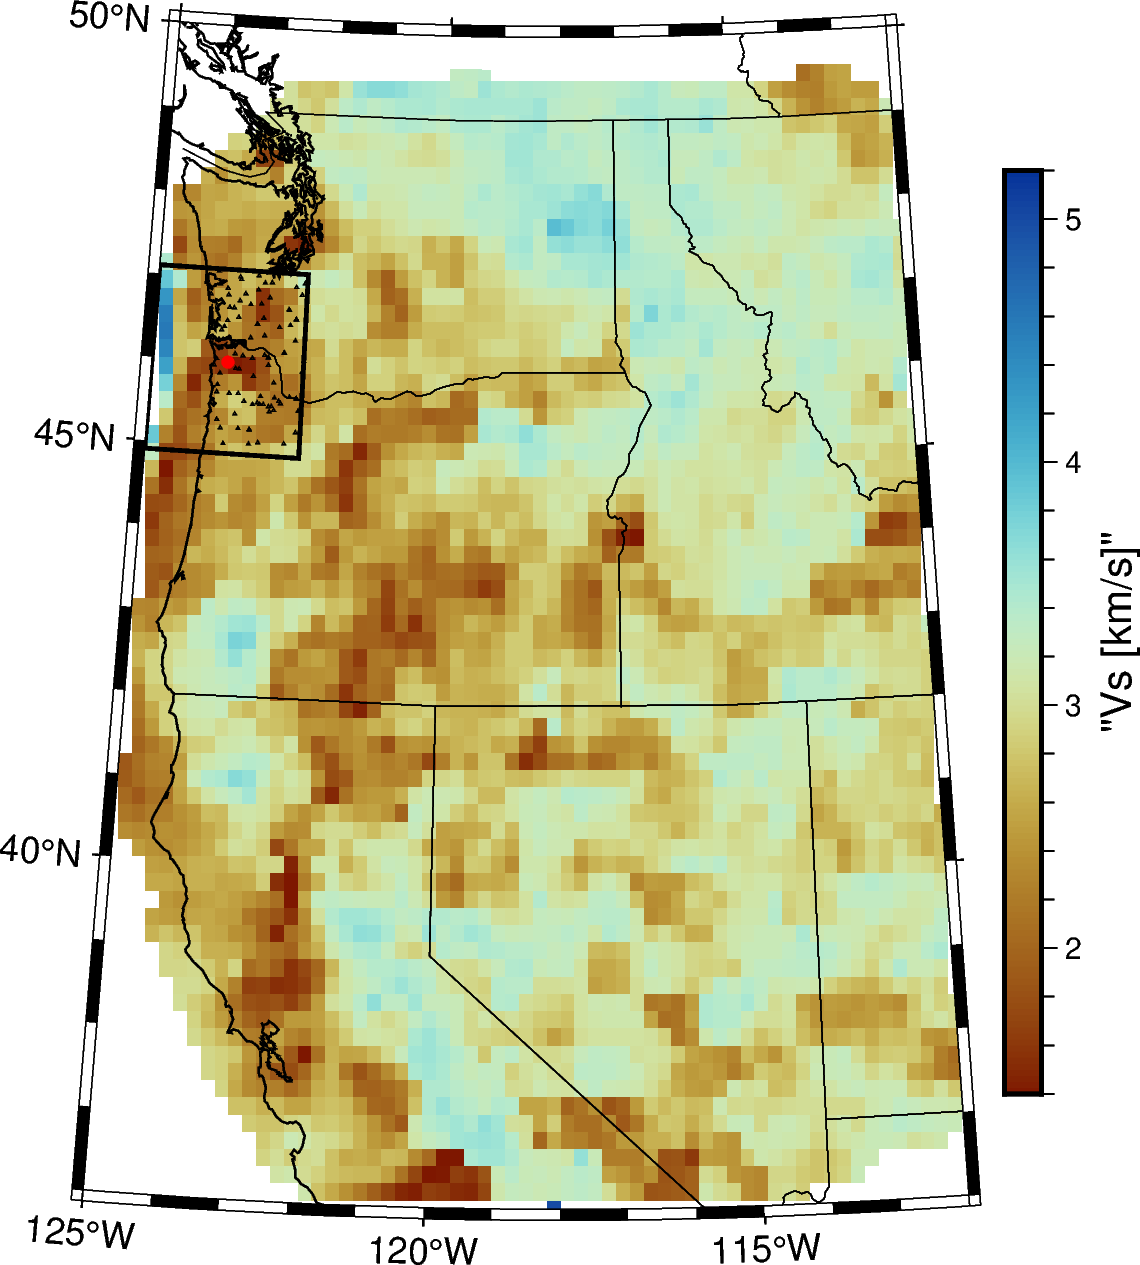

In [60]:
### Example PyGMT Map

# Depth for horizontal slice
depth = 0

# Setting variables related to the colorscale
vmin1 = 1.400
vmax1 = 5.200
vspace = 0.025
vs1_series = (vmin1, vmax1, vspace)
vs1_above = [vmax1,vmax1]
vs1_below = [vmin1,vmin1]

#Setting projection variables
projection = 'L-118/44/36/49/7.5c'
region = [-125,-112,36,50]

# map figure
fig = pygmt.Figure()

# make colormap
pygmt.makecpt(cmap="roma", series=vs1_series)

# Plot a 5km map view slice of the model in isotropic Vs
fig.grdimage(grid=pygmt.grdclip(velocity['Vs_interp'].sel(depth=depth), 
                                below=vs1_below, above=vs1_above), projection=projection)
fig.colorbar(frame='af+l"Vs [km/s]"',position="JMR+o0.3c/0c")

# Coast
fig.coast(shorelines = '1/0.5p', region = region, projection=projection,
            frame = ['af'], borders=["1/black", "2/black"])

# stations
fig.plot(x=sdf["Longitude"],y=sdf["Latitude"],style="t1p")

# origin
fig.plot(x=olon,y=olat,style="c3p",fill="red")

# selected polygon
fig.plot(x=[poly_param['minlon'], poly_param['minlon'], poly_param['maxlon'], poly_param['maxlon'], poly_param['minlon']],
         y=[poly_param['minlat'], poly_param['maxlat'], poly_param['maxlat'], poly_param['minlat'], poly_param['minlat']]
        , pen="1p, black")


# Show Results
# fig.savefig("./velocity_depth5.png", dpi=300)
fig.show()

## project velocity to polygon

In [61]:
### Compile DataFrame Using Scipy Interpolate
#  - The Xarray version is much slower and crashes...

# first get flattened arrays for output grid
x_flat, y_flat = np.ravel(xgrid), np.ravel(ygrid)
out_lonflat, out_latflat = np.ravel(lon_grid), np.ravel(lat_grid)

# from velocity model
longrid, latgrid = np.meshgrid(
    np.asarray(velocity.lon), np.asarray(velocity.lat))
print(longrid.shape)
vel_lonflat = np.ravel(longrid)
vel_latflat = np.ravel(latgrid)

# 2D arrays as input for scipy.interpolate
out_obs = np.vstack([out_lonflat, out_latflat]).T
vel_obs = np.vstack([vel_lonflat, vel_latflat]).T

# store data here
xvals, yvals, zvals, vpvals, vsvals = [], [], [], [], []

# loop over depths
for zz in np.arange(-4.0, zmax+zsep, zsep): 
    vel_vp = np.ravel(velocity['Vp_interp'].interp(depth = zz, method = 'linear').values)
    vel_vs = np.ravel(velocity['Vs_interp'].interp(depth = zz, method = 'linear').values)
    # interpolation
    out_vp = interpolate.griddata(vel_obs, vel_vp, out_obs, method="linear")
    out_vs = interpolate.griddata(vel_obs, vel_vs, out_obs, method="linear")

    # update
    xvals.append(x_flat)
    yvals.append(y_flat)
    zvals.append(zz + np.zeros(y_flat.size))
    vpvals.append(out_vp) # km/s
    vsvals.append(out_vs) # km/s

    # progress
    if np.mod(zz,10.0) < 0.1: print("Done with depth",zz)

# completed everything
print("Done")

(68, 65)
Done with depth 0.0
Done with depth 10.0
Done with depth 20.0
Done with depth 30.0
Done with depth 40.0
Done with depth 50.0
Done with depth 60.0
Done with depth 70.0
Done with depth 80.0
Done with depth 90.0
Done with depth 100.0
Done


In [62]:
## Turn This Into DataFrame

# make dataframe
odf = pd.DataFrame({
    "x": np.hstack(xvals),
    "y": np.hstack(yvals),
    "z": np.hstack(zvals),
    "vp": np.hstack(vpvals),
    "vs": np.hstack(vsvals),
})

# grid points
xg= odf["x"].unique()
yg = odf["y"].unique()
zg = odf["z"].unique()
nx, ny, nz = len(xg), len(yg), len(zg)
print(nx, ny, nz)

# test groupby z and y
gdf = odf.groupby(["z","y"])
print(gdf.get_group((15.0,-100.0)))

# show 
odf

125 125 105
            x      y     z        vp        vs
298375 -124.0 -100.0  15.0       NaN       NaN
298376 -122.0 -100.0  15.0       NaN       NaN
298377 -120.0 -100.0  15.0       NaN       NaN
298378 -118.0 -100.0  15.0       NaN       NaN
298379 -116.0 -100.0  15.0       NaN       NaN
...       ...    ...   ...       ...       ...
298495  116.0 -100.0  15.0  6.192784  3.538732
298496  118.0 -100.0  15.0  6.195986  3.540562
298497  120.0 -100.0  15.0  6.193055  3.538888
298498  122.0 -100.0  15.0  6.189876  3.537071
298499  124.0 -100.0  15.0  6.186695  3.535254

[125 rows x 5 columns]


,x,y,z,vp,vs
0,-124.0,-124.0,-4.0,NaN,NaN
1,-122.0,-124.0,-4.0,NaN,NaN
2,-120.0,-124.0,-4.0,NaN,NaN
3,-118.0,-124.0,-4.0,NaN,NaN
4,-116.0,-124.0,-4.0,NaN,NaN
...,...,...,...,...,...
1640620,116.0,124.0,100.0,7.325150,4.185799
1640621,118.0,124.0,100.0,7.362251,4.206999
1640622,120.0,124.0,100.0,7.399359,4.228203
1640623,122.0,124.0,100.0,7.434268,4.248152


<xarray.DataArray 'Vs_interp' (lat: 68, lon: 65)> Size: 35kB
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ..., 2.5081,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]])
Coordinates:
  * lat      (lat) float64 544B 36.0 36.2 36.4 36.6 36.8 ... 48.8 49.0 49.2 49.4
  * lon      (lon) float64 520B -124.8 -124.6 -124.4 ... -112.4 -112.2 -112.0
    depth    float64 8B 0.0
vmin=1.0172, vmax=5.138352709337095


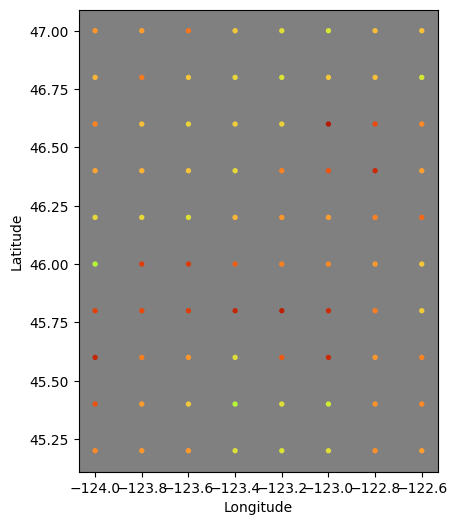

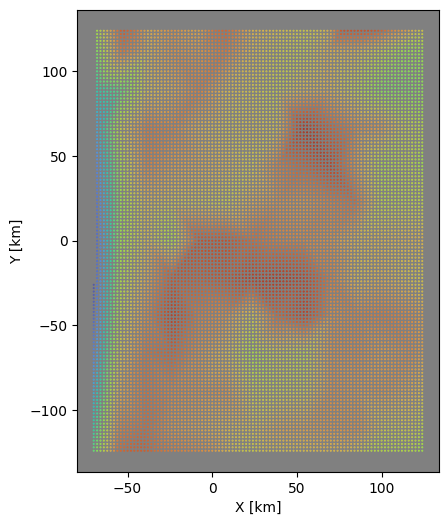

In [64]:
### Test Plot - Notice the Shallow NaN values for interp

test_depth = 0.0


# select data from the xarray
data = velocity["Vs_interp"].interp(depth = test_depth, method = "linear")
vmin = data.min().data
vmax = data.max().data

print(data)
print(f"vmin={vmin}, vmax={vmax}")
lons = np.asarray(data.lon)
lats = np.asarray(data.lat)
mx, my = np.meshgrid(lons,lats)
fx, fy = np.ravel(mx), np.ravel(my)
md = np.ravel(data.values)

# only within the study region bounds
idx = (fx>=slon0)&(fx<=slon1)&(fy>=slat0)&(fy<=slat1)


# plot results to check
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(fx[idx],fy[idx],s=8,c=md[idx],vmin=vmin,vmax=vmax,
            cmap=plt.cm.turbo_r)
axi.set_xlabel("Longitude")
axi.set_ylabel("Latitude")
plt.show()


# select data from dataframe 
zdf = odf.groupby("z").get_group(test_depth)

# now plot results to check
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(zdf["x"],zdf["y"],s=0.15,c=zdf["vs"], vmin=vmin, vmax=vmax,
            cmap=plt.cm.turbo_r)
axi.set_xlabel("X [km]")
axi.set_ylabel("Y [km]")
plt.show()

# fill NaNs

In [65]:
# Function to fill NaN values using nearest neighbors
def fill_nan_with_nearest_neighbors(df, columns):
    for z_val in df['z'].unique():
        subset = df[df['z'] == z_val]
        for col in columns:
            mask = subset[col].notna()
            points = subset[mask][['x', 'y']].values
            values = subset[mask][col].values
            grid = subset[['x', 'y']].values
            filled_values = interpolate.griddata(points, values, grid, method='nearest')
            df.loc[df['z'] == z_val, col] = filled_values
    return df

# Fill NaN values for vp and vs
odf = fill_nan_with_nearest_neighbors(odf, ['vp', 'vs'])
odf

,x,y,z,vp,vs
0,-124.0,-124.0,-4.0,5.967288,3.409882
1,-122.0,-124.0,-4.0,5.967288,3.409882
2,-120.0,-124.0,-4.0,5.967288,3.409882
3,-118.0,-124.0,-4.0,5.967288,3.409882
4,-116.0,-124.0,-4.0,5.967288,3.409882
...,...,...,...,...,...
1640620,116.0,124.0,100.0,7.325150,4.185799
1640621,118.0,124.0,100.0,7.362251,4.206999
1640622,120.0,124.0,100.0,7.399359,4.228203
1640623,122.0,124.0,100.0,7.434268,4.248152


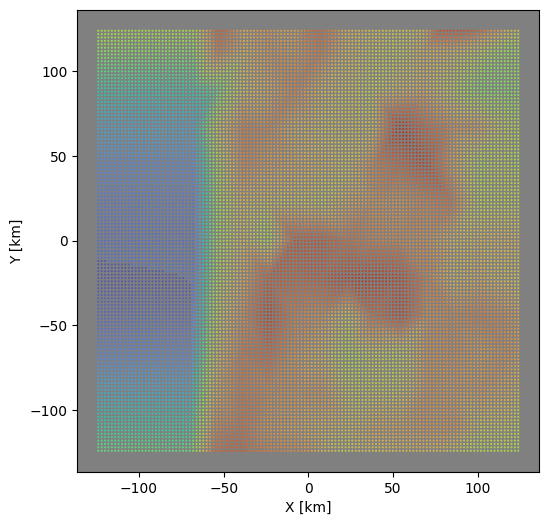

In [66]:
# select data from dataframe 
zdf = odf.groupby("z").get_group(test_depth)

# now plot results to check
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(zdf["x"],zdf["y"],s=0.15,c=zdf["vs"], vmin=vmin, vmax=vmax,
            cmap=plt.cm.turbo_r)
axi.set_xlabel("X [km]")
axi.set_ylabel("Y [km]")
plt.show()

# Save velocity grid

In [67]:
### Write Vp Grid

# open output file
with open(out_fileP,"w") as f:
    
    # header line
    unit, nph = 1.0, 2 # grid units are 1km, 2 phases
    f.writelines("%f %d %d %d %d # SimulPS P-wave Model\n" %(unit,nx,ny,nz,nph))
    
    # write xgrid, ygrid, zgrid
    s = " ".join("%.1f" %x for x in xg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %y for y in yg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %z for z in zg) + "\n"
    f.writelines(s)
    
    # dummy lines
    f.writelines("0 0 0\n\n")
    
    # loop over z, then y, then write all x
    gdf = odf.groupby(["z","y"])
    for zval in zg:
        for yval in yg:
            df = gdf.get_group((zval,yval))
            vdata = df["vp"].values
            s = " ".join("%.2f" %v for v in vdata) + "\n"
            f.writelines(s)

# write results
print("Done with",out_fileP)

Done with ../locations/nlloc3D/model/delph_simulps_poly3_lcc_200R_P.txt


In [68]:
### Write Vs Grid

# open output file
with open(out_fileS,"w") as f:
    
    # header line
    unit, nph = 1.0, 2 # grid units are 1km, 2 phases
    f.writelines("%f %d %d %d %d # SimulPS S-wave Model\n" %(unit,nx,ny,nz,nph))
    
    # write xgrid, ygrid, zgrid
    s = " ".join("%.1f" %x for x in xg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %y for y in yg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %z for z in zg) + "\n"
    f.writelines(s)
    
    # dummy lines
    f.writelines("0 0 0\n\n")
    
    # loop over z, then y, then write all x
    gdf = odf.groupby(["z","y"])
    for zval in zg:
        for yval in yg:
            df = gdf.get_group((zval,yval))
            vdata = df["vs"].values
            s = " ".join("%.2f" %v for v in vdata) + "\n"
            f.writelines(s)

# write results
print("Done with",out_fileS)

Done with ../locations/nlloc3D/model/delph_simulps_poly3_lcc_200R_S.txt


In [69]:
print("DONE, Polygon",poly)

DONE, Polygon 3
